# Building Graph Neural Network for NLP task

In [1]:
# Install required packages.
import os
import torch
import json
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from gensim.models import Word2Vec
Tokenizer = Okt()

path = os.path.dirname(os.getcwd())
print(path)

1.12.0
/home/vips/share/Vu


## Build dataset graph

In [2]:
base_params = {

## model ["CS2S", "RNN", "RNNA", "TRANS"]
    "NAME": "GNN",
    
## Path params
    "DATA": os.path.join("NLP_data", "nsmc_train.json"),
    "MODEL_NAME": "ko_word2vec.model",

## Data params
    "INPUT_DIM": 128,
    "N_CLASSES": 2,

## Model params
    "HIDDEN": 128,
   

## Training params
    "BATCH_FIRST": True,
    "ENC_DROPOUT": 0.1,
    "DEC_DROPOUT": 0.1,
    "LR": 0.01,
    "WARMUP_RATIO": 0.2,
    "MAX_EPOCHES": 500,
    "BATCH_SZ": 128
}

###  Load dataset

In [3]:
pos_remove = ["Eomi", "Punctuation", "Unknown", "KoreanParticle", "Hashtag", "ScreenName",
                    "Email", "URL", "PreEomi", "Foreign"]

def simple_process_tokens(sent):
    tokens = Tokenizer.pos(sent, stem=True, norm=True)
    out = []
    for (token, type) in tokens:
        if(type in pos_remove): 
            continue
        else:
            out.append(token)
    return out


# sentences = []

# with open(os.path.join("NLP_data", "nsmc", "ratings_train.txt"), 'r') as f:
#     for line in f.readlines()[1:]:
#         sent = line.split("\t")
#         sentences += [(sent[1], int(sent[2]))]

# sentences = []

# with open(os.path.join("NLP_data", "nsmc", "ratings_test.txt"), 'r') as f:
#     for line in f.readlines()[1:]:
#         sentences += [line.split("\t")[1]]



In [4]:
from torch_geometric.data import Data, Dataset
import itertools

class EdgeEncoder(object):
    def __init__(self, model_name='ko_word2vec.model', dtype=None):
        self.dtype = dtype
        self.model = Word2Vec.load(model_name)

    def __call__(self, node1, node2):

        try:
            edge_weight = self.model.wv.similarity(node1, node2)
            edge_weight = torch.tensor(edge_weight).to(self.dtype)
        except:
            edge_weight = torch.tensor(0.).to(self.dtype)
        return edge_weight

class SequenceEncoder(object):
    def __init__(self, model_name='ko_word2vec.model', dtype=None, size=128):
        
        self.model = Word2Vec.load(model_name)
        self.dtype = dtype
        self.size = size

    def __call__(self, word):

        try:
            x = self.model.wv[word]
            x = torch.from_numpy(x).view(self.size).to(self.dtype)
        except:
            x = torch.zeros(self.size).to(self.dtype)
        return x


class NSMC_Graph(Dataset):
    def __init__(self, sentences, args):
        super().__init__()

        self.sentences = sentences
        
        self.size = args["INPUT_DIM"]
        self.node_encoder = SequenceEncoder(args["MODEL_NAME"], dtype=torch.float, size=self.size)
        self.edge_encoder = EdgeEncoder(args["MODEL_NAME"], dtype=torch.float)

    def len(self):
        return len(self.sentences)

    def get(self, idx, return_sample=False):
        data = self.sentences[idx]
        # print(data[0])
        tokens = data[1]
       
        xs = [self.node_encoder(token) for token in tokens]
        edge_index = list(itertools.product(range(len(tokens)), range(len(tokens))))
        edge_attr = [self.edge_encoder(tokens[i], tokens[j]) for (i, j) in edge_index]
       
        edge_index = torch.tensor(edge_index)
        edge_attr = torch.stack(edge_attr)
        x = torch.stack(xs)
        label = torch.tensor(data[2]).to(torch.long)
        if(return_sample == True): 
            return Data(x=x, edge_index=edge_index.T, edge_weight=edge_attr, y=label), tokens
        else:
            return Data(x=x, edge_index=edge_index.T, edge_weight=edge_attr, y=label)



In [5]:

with open(os.path.join("NLP_data", "nsmc_test.json"), 'r') as f:
    nscm_data = json.load(f)
   

dataset = NSMC_Graph(nscm_data[:200], base_params)
data = dataset[5]
print(data)
print(data.edge_weight)
print(data.x)

Data(x=[8, 128], edge_index=[2, 64], y=1, edge_weight=[64])
tensor([ 1.0000e+00,  9.8374e-02, -2.7609e-01,  5.1343e-02,  1.8994e-01,
         1.4594e-01,  1.0000e+00,  2.8383e-01,  9.8374e-02,  1.0000e+00,
         1.4512e-01,  1.8432e-01,  6.3822e-02,  3.2599e-01,  9.8374e-02,
         1.8150e-01, -2.7609e-01,  1.4512e-01,  1.0000e+00, -6.0154e-02,
        -1.7927e-02, -5.0070e-02, -2.7609e-01,  1.6235e-02,  5.1343e-02,
         1.8432e-01, -6.0154e-02,  1.0000e+00,  3.2776e-02,  2.5471e-01,
         5.1343e-02,  2.7556e-02,  1.8994e-01,  6.3822e-02, -1.7927e-02,
         3.2776e-02,  1.0000e+00,  1.1720e-04,  1.8994e-01,  2.1631e-01,
         1.4594e-01,  3.2599e-01, -5.0070e-02,  2.5471e-01,  1.1720e-04,
         1.0000e+00,  1.4594e-01, -9.8896e-02,  1.0000e+00,  9.8374e-02,
        -2.7609e-01,  5.1343e-02,  1.8994e-01,  1.4594e-01,  1.0000e+00,
         2.8383e-01,  2.8383e-01,  1.8150e-01,  1.6235e-02,  2.7556e-02,
         2.1631e-01, -9.8896e-02,  2.8383e-01,  1.0000e+00])
ten

/tmp/ipykernel_4622/2253016785.py:29: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  x = torch.from_numpy(x).view(self.size).to(self.dtype)


In [6]:
from torch_geometric.utils import to_networkx

def draw_graph(g, labels, edge_mask=None, draw_edge_labels=False):
    # g = g.copy().to_undirected()
    g = to_networkx(g, edge_attrs=["edge_weight"], to_undirected=True)
    node_labels = {}
    for i in range(len(labels)):
        node_labels[i] = labels[i]
        
    # pos = nx.planar_layout(g)
    # pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [data["edge_weight"] for u, v, data in g.edges(data=True)]
        widths = [x * 5 for x in edge_color]

    # fontprop = fm.FontProperties(fname='NanumGothic.otf', size=18)
    nx.draw(g, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure', font_family="NanumBarunGothic")
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

(Data(x=[5, 128], edge_index=[2, 25], y=0, edge_weight=[25]), ['글쌔', '슬프다', '너무', '짜이다', '한'])


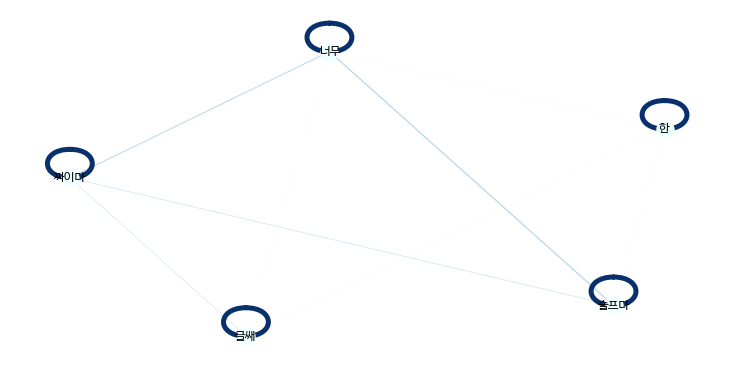

In [7]:
import random

i = random.choice(range(dataset.len()))
data = dataset.get(i, return_sample=True)
print(data)
plt.figure(figsize=(10, 5))

draw_graph(g = data[0], labels=data[1], edge_mask=True)

In [8]:
from torch_geometric.loader import DataLoader

dataset = NSMC_Graph(nscm_data, base_params)

dataset = dataset[:10]
loader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for graph in loader:
    print(graph.is_cuda)
    graph = graph.to(device)
    print(graph.is_cuda)
    print(graph)
    break

False
True
DataBatch(x=[118, 128], edge_index=[2, 2236], y=[10], edge_weight=[2236], batch=[118], ptr=[11])


In [19]:
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split


class DataModule(pl.LightningDataModule):

    def __init__(self, args):
        super().__init__()
        self.data_dir = args["DATA"]
        self.batch_size = args["BATCH_SZ"]
        self.args = args
        self.prepare_data()

    def prepare_data(self):

        self.sentences = []
        with open(self.data_dir, 'r') as f:
            sentences = json.load(f)
            for sentence in sentences:
                if(len(sentence[1]) > 0):
                    self.sentences.append(sentence)
        self.sentences = self.sentences[:len(self.sentences)//10]
        print("load %d samples"%(len(self.sentences)))
       
        
    def setup(self, stage: str):
        
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            self._train, self._val = train_test_split(self.sentences, test_size=0.3)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self._test = self.sentences
        
    def train_dataloader(self):
        return DataLoader(
                NSMC_Graph(self._train, args=self.args),
                batch_size=self.batch_size,
                shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(
                NSMC_Graph(self._val, args=self.args),
                batch_size=self.batch_size,
                shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(
                NSMC_Graph(self._test, args=self.args),
                batch_size=self.batch_size,
                shuffle=False)

In [10]:
datamodule = DataModule(args=base_params)
datamodule.setup(stage="fit")

for batch in datamodule.train_dataloader():
    print(batch)
    break

load 15000 samples
DataBatch(x=[1610, 128], edge_index=[2, 34634], y=[128], edge_weight=[34634], batch=[1610], ptr=[129])


## Define model

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim, num_features, num_classes):
        super(Net, self).__init__()

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        torch.nn.init.xavier_uniform_(m.weight.data)

## Trainer

In [20]:
import pytorch_lightning as pl
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNN(pl.LightningModule):

    def __init__(self, kwargs):
        super(GNN, self).__init__()

        if(kwargs["NAME"] == "GNN"):

            self.model = Net(dim = kwargs["INPUT_DIM"], num_features=kwargs["HIDDEN"], num_classes=kwargs["N_CLASSES"]).to(device)
            initialize_weights(self.model)
        
        self.loss_function = torch.nn.NLLLoss()
        self.kwargs = kwargs
        
    def configure_optimizers(self):
        # Prepare optimizer
        
        # param_optimizer = list(self.named_parameters())
        # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        # optimizer_grouped_parameters = [
        #    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        #    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        # ]
        optimizer = torch.optim.AdamW(self.parameters(), lr= self.kwargs["LR"])
        # warm up lr
        num_train_steps = len(self.trainer._data_connector._train_dataloader_source.dataloader()) * self.kwargs["MAX_EPOCHES"] ##because of lighting problem from 1.5 version
        num_warmup_steps = int(num_train_steps * self.kwargs["WARMUP_RATIO"])
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
        lr_scheduler = {'scheduler': scheduler, 'name': 'cosine_schedule_with_warmup',
                        'monitor': 'loss', 'interval': 'step',
                        'frequency': 1}
        return [optimizer], [lr_scheduler]

    def forward(self, x, edge_index, batch, edge_weight=None):
        
        output = self.model(x, edge_index, batch)
        return output

    def cal_loss(self, outputs, trg):
        
        return self.loss_function(outputs, trg)

    def training_step(self, batch, batch_idx):
        batch = batch.to(device)
        outputs = self(x=batch.x, edge_index=batch.edge_index, batch=batch.batch, edge_weight=batch.edge_weight)
        loss = self.cal_loss(outputs, batch.y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, batch_size=self.kwargs["BATCH_SZ"])
        return loss

    def validation_step(self, batch, batch_idx):
        batch = batch.to(device)
       
        outputs = self(x=batch.x, edge_index=batch.edge_index, batch=batch.batch, edge_weight=batch.edge_weight)
        loss = self.cal_loss(outputs, batch.y)
    
        self.log('val_loss', loss, batch_size=self.kwargs["BATCH_SZ"])
        
    def test_step(self, batch, batch_idx):
        batch = batch.to(device)
        outputs = self(x=batch.x, edge_index=batch.edge_index, batch=batch.batch, edge_weight=batch.edge_weight)
        loss = self.cal_loss(outputs, batch.y)
        
        _, outs = torch.max(outputs, dim=-1)
        target = batch.y
        
        self.log('test_loss', loss, batch_size=self.kwargs["BATCH_SZ"])
        return {'output': outs, 'label': target} #be careful, it gathers data on each GPUs so the data will be split

    def test_epoch_end(self, test_step_outputs):
        acc = []
        
        for out in test_step_outputs:

            labels = out["label"]
            outputs = out["output"]
            
            acc += [outputs.eq(labels).sum().item() / self.kwargs["BATCH_SZ"]]
        print("Accuracy: ", (np.array(acc)).mean())

## Test model

In [13]:
data_module = DataModule(args=base_params)
data_module.setup(stage="fit")

load 15000 samples


In [14]:
model = GNN(kwargs=base_params)
loss = torch.nn.NLLLoss()
batch = next(iter(data_module.train_dataloader())).to(device)
outputs = model(batch.x, batch.edge_index, batch.batch)

print(outputs.type())
print(outputs.size())
l = loss(outputs, batch.y)
print(l)

torch.cuda.FloatTensor
torch.Size([128, 2])
tensor(612826.9375, device='cuda:0', grad_fn=<NllLossBackward0>)


## Training

In [15]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import ModelCheckpoint

# data_module = DataModule(args=base_params)
# data_module.setup(stage="fit")

# checkpoint_callback = ModelCheckpoint(
#     # dirpath='model_chp',
#     filename='{epoch:02d}',
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# model = GNN(kwargs=base_params)
# trainer = Trainer(
#     callbacks=checkpoint_callback,
#     max_epochs=base_params["MAX_EPOCHES"],
#     gradient_clip_val=1.0,
#     accelerator="gpu",
#     devices=1,
#     strategy="dp",
#     )

# trainer.fit(model, data_module)
# print('best model path {}'.format(checkpoint_callback.best_model_path))

In [21]:
from pytorch_lightning import Trainer

data_module = DataModule(args=base_params)
data_module.setup(stage="test")
model = GNN(kwargs=base_params)
trainer = Trainer(accelerator="gpu", strategy="dp", gpus=[0])
trainer.test(model=model, datamodule=data_module, ckpt_path="lightning_logs/graph_CNN/checkpoints/epoch=60.ckpt")

/home/vips/anaconda3/envs/GNN/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


load 14937 samples


Restoring states from the checkpoint path at lightning_logs/graph_CNN/checkpoints/epoch=60.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at lightning_logs/graph_CNN/checkpoints/epoch=60.ckpt


load 14937 samples


/home/vips/anaconda3/envs/GNN/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/vips/anaconda3/envs/GNN/lib/python3.10/site-packages/pytorch_lightning/overrides/data_parallel.py:99: UserWarning: Could not determine on which device the inputs are. When using DataParallel (strategy='dp'), be aware that in case you are using self.device in your code, it will reference only the root device.
  rank_zero_warn(


Accuracy:  0.6615251068376068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6247313022613525
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6247313022613525}]